In [8]:
#lettura dati

def leggi_dati(file_path):
    # Inizializza liste per ogni colonna
    angle, rate, err_rate = [], [], []
    count, err_count = [], []
    channel, err_channel = [], []
    sigma, err_sigma = [], []

    with open(file_path, 'r') as file:
        lines = file.readlines()

        # Salta l'intestazione
        for line in lines[1:]:
            valori = line.strip().split()
            if len(valori) != 9:
                continue  # Salta righe non valide

            angle.append(float(valori[0]))
            rate.append(float(valori[1]))
            err_rate.append(float(valori[2]))
            count.append(float(valori[3]))
            err_count.append(float(valori[4]))
            channel.append(float(valori[5]))
            err_channel.append(float(valori[6]))
            sigma.append(float(valori[7]))
            err_sigma.append(float(valori[8]))

    return angle, rate, err_rate, count, err_count, channel, err_channel, sigma, err_sigma

file_path = "../Codes/data_analysis/parameters_pol4_riflection.txt"

angle, rate, err_rate, count, err_count, channel, err_channel, sigma, err_sigma = leggi_dati(file_path)

file_path = "../Codes/data_analysis/parameters_pol4_trasmission.txt"

angle_trasm, rate_trasm, err_rate_trasm, count_trasm, err_count_trasm, channel_trasm, err_channel_trasm, sigma_trasm, err_sigma_trasm = leggi_dati(file_path)

In [9]:
import numpy as np

data = np.load('../Measurments/errori_arrays_energies_riflex.npz')
y_err = data['y_err']
x_err = data['x_err']

print(y_err, x_err)

data = np.load('../Measurments/errori_arrays_energies_trasm.npz')
y_err_trasm = data['y_err']
x_err_trasm = data['x_err']

print(y_err_trasm, x_err_trasm)

[22.84938822 24.73515897 25.06882476 24.16920639 23.90927847 23.60367868
 23.7813561  21.84229732] 0.026549250386340584
[21.86974645 22.60325593 23.58308884 24.5744343 ] 0.026549250386340584


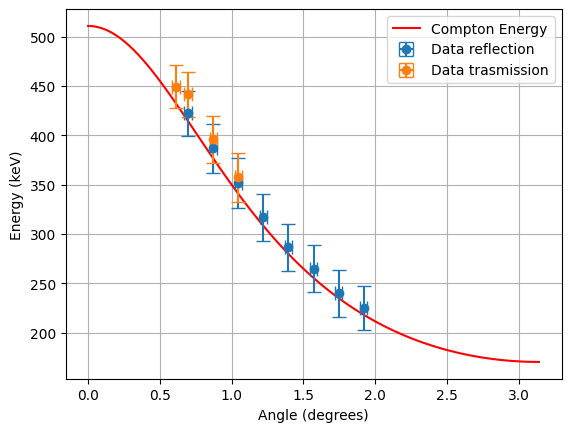

In [10]:
import matplotlib.pyplot as plt

def compton_energy(theta): 
    return 511 / (2 - np.cos(theta))

def calibration(x, a = 0.36, b = -11.5):
    """
    Calibration function for converting ADC channels to energy in keV.
    
    :param x: ADC channel value.
    :param a: Calibration coefficient (default: 0.36).
    :param b: Calibration offset (default: -11.5).
    :return: Energy in keV.
    """
    return a * x + b

thetas = np.linspace(0, np.pi, 100)
angle = np.radians(angle)
angle_trasm = np.radians(angle_trasm)
energies = calibration(np.array(channel))
energies_trasm = calibration(np.array(channel_trasm))

plt.plot(thetas, compton_energy(thetas), label='Compton Energy', color='red')
plt.errorbar(angle, energies, xerr=x_err, yerr=y_err, fmt='o', capsize=5, label='Data reflection')
plt.errorbar(angle_trasm, energies_trasm, xerr=x_err_trasm, yerr=y_err_trasm, fmt='o', capsize=5, label='Data trasmission')
plt.xlabel('Angle (degrees)')
plt.ylabel('Energy (keV)')
plt.legend()
plt.grid()
plt.show()

TRASMISSIONE
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │    640    │    90     │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
Chi2: 0.36, NDF: 3.0


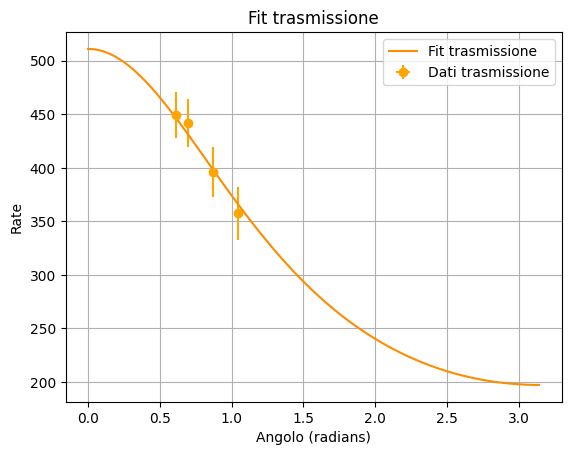


--- RISULTATI TRASMISSIONE ---
Fitted value of a: 642.4938618781031
Error on a: 92.91261551301
Compatibilità:  -1.4152422806318565


In [11]:
from iminuit import Minuit
from iminuit.cost import LeastSquares

# === Funzione da fittare ===
def fit_function(theta, a):
    return 511 / (1 + (511/a) * (1 - np.cos(theta)))

# === Fit ===
least_squares = LeastSquares(angle_trasm, energies_trasm, y_err_trasm, fit_function)
m = Minuit(least_squares, a=511)
m.migrad()

# === Risultati ===
print("TRASMISSIONE")
print(m.params)
print(f"Chi2: {m.fval:.2f}, NDF: {m.ndof}")

# === Plot ===
plt.errorbar(angle_trasm, energies_trasm, yerr=y_err_trasm, xerr=x_err_trasm, fmt='o', color='orange', label='Dati trasmissione')
a_fit_trasmission = m.values["a"]
a_err_trasmission = m.errors["a"]
plt.plot(thetas, fit_function(thetas, a_fit_trasmission), label="Fit trasmissione", color='darkorange')

plt.xlabel("Angolo (radians)")
plt.ylabel("Rate")
plt.legend()
plt.grid()
plt.title("Fit trasmissione")
plt.show()

# === Calcolo m_e ===
print("\n--- RISULTATI TRASMISSIONE ---")
print(f"Fitted value of a: {a_fit_trasmission}")
print(f"Error on a: {a_err_trasmission}")


# === Confronto tra r_e ottenuti da riflessione e trasmissione ===
R = (511 - a_fit_trasmission) / a_err_trasmission
print ("Compatibilità: ", R)


TRASMISSIONE
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │    550    │    40     │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
Chi2: 0.10, NDF: 7.0


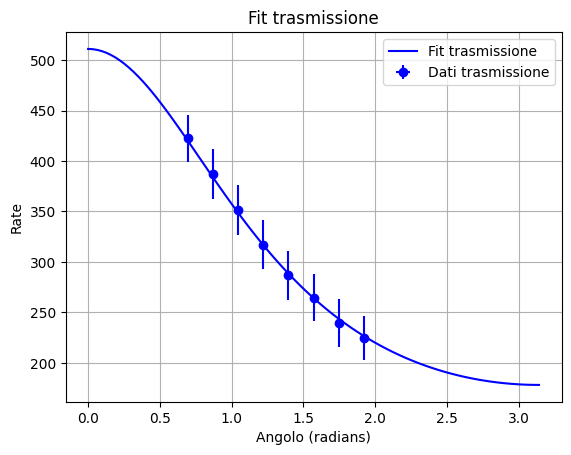


--- RISULTATI TRASMISSIONE ---
Fitted value of a: 547.4315352606038
Error on a: 39.71687192696382
Compatibilità:  -0.9172810821456063


In [12]:
# === Fit ===
least_squares = LeastSquares(angle, energies, y_err, fit_function)
m = Minuit(least_squares, a=511)
m.migrad()

# === Risultati ===
print("TRASMISSIONE")
print(m.params)
print(f"Chi2: {m.fval:.2f}, NDF: {m.ndof}")

# === Plot ===
plt.errorbar(angle, energies, yerr=y_err, xerr=x_err, fmt='o', color='blue', label='Dati trasmissione')
a_fit_reflection = m.values["a"]
a_err_reflection = m.errors["a"]
plt.plot(thetas, fit_function(thetas, a_fit_reflection), label="Fit trasmissione", color='blue')

plt.xlabel("Angolo (radians)")
plt.ylabel("Rate")
plt.legend()
plt.grid()
plt.title("Fit trasmissione")
plt.show()

# === Calcolo m_e ===
print("\n--- RISULTATI TRASMISSIONE ---")
print(f"Fitted value of a: {a_fit_reflection}")
print(f"Error on a: {a_err_reflection}")


# === Confronto tra r_e ottenuti da riflessione e trasmissione ===
R = (511 - a_fit_reflection) / a_err_reflection
print ("Compatibilità: ", R)


(12,) (12,) (12,)
TOTALE
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │    570    │    40     │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
Chi2: 1.49, NDF: 11.0


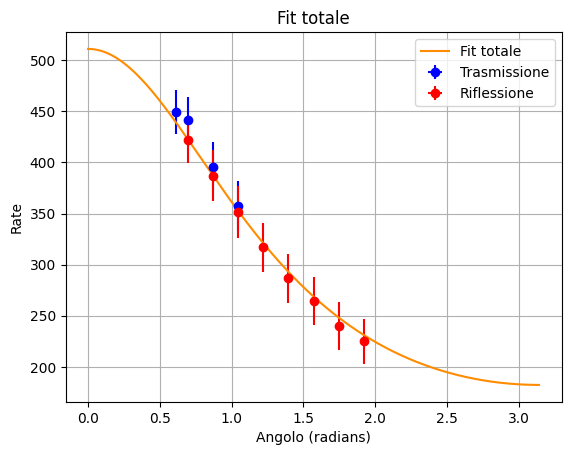


--- RISULTATI TRASMISSIONE ---
Fitted value of a: 567.0011908593509
Error on a: 36.21402202985177
Compatibilità:  -1.5463952281574325


In [13]:
# === Dataset totale per il fit ===
data_tot = np.concatenate((energies_trasm, energies))
angle_tot = np.radians(np.array([35, 40, 50, 60, 40, 50, 60, 70, 80, 90, 100, 110]))
data_err = np.concatenate((y_err_trasm, y_err))
print(data_tot.shape, angle_tot.shape, data_err.shape)

# === Fit ===
least_squares_trasm = LeastSquares(angle_tot, data_tot, data_err, fit_function)
m = Minuit(least_squares_trasm, a=511.0)
m.migrad()

# === Risultati ===
print("TOTALE")
print(m.params)
print(f"Chi2: {m.fval:.2f}, NDF: {m.ndof}")

# === Plot ===
thetas = np.linspace(0, np.pi, 2000)
a_fit_tot = m.values["a"]
a_err_tot = m.errors["a"]

plt.errorbar(angle_trasm, energies_trasm, yerr=y_err_trasm, xerr=x_err_trasm, fmt='o', label="Trasmissione", color='blue')
plt.errorbar(angle, energies, yerr=y_err, xerr=x_err, fmt='o', label="Riflessione", color='red')
plt.plot(thetas, fit_function(thetas, a_fit_tot), label="Fit totale", color='darkorange')

plt.xlabel("Angolo (radians)")
plt.ylabel("Rate")
plt.legend()
plt.grid()
plt.title("Fit totale")
plt.show()

# === Calcolo m_e ===
print("\n--- RISULTATI TRASMISSIONE ---")
print(f"Fitted value of a: {a_fit_tot}")
print(f"Error on a: {a_err_tot}")


# === Confronto tra r_e ottenuti da riflessione e trasmissione ===
R = (511 - a_fit_tot) / a_err_tot
print ("Compatibilità: ", R)

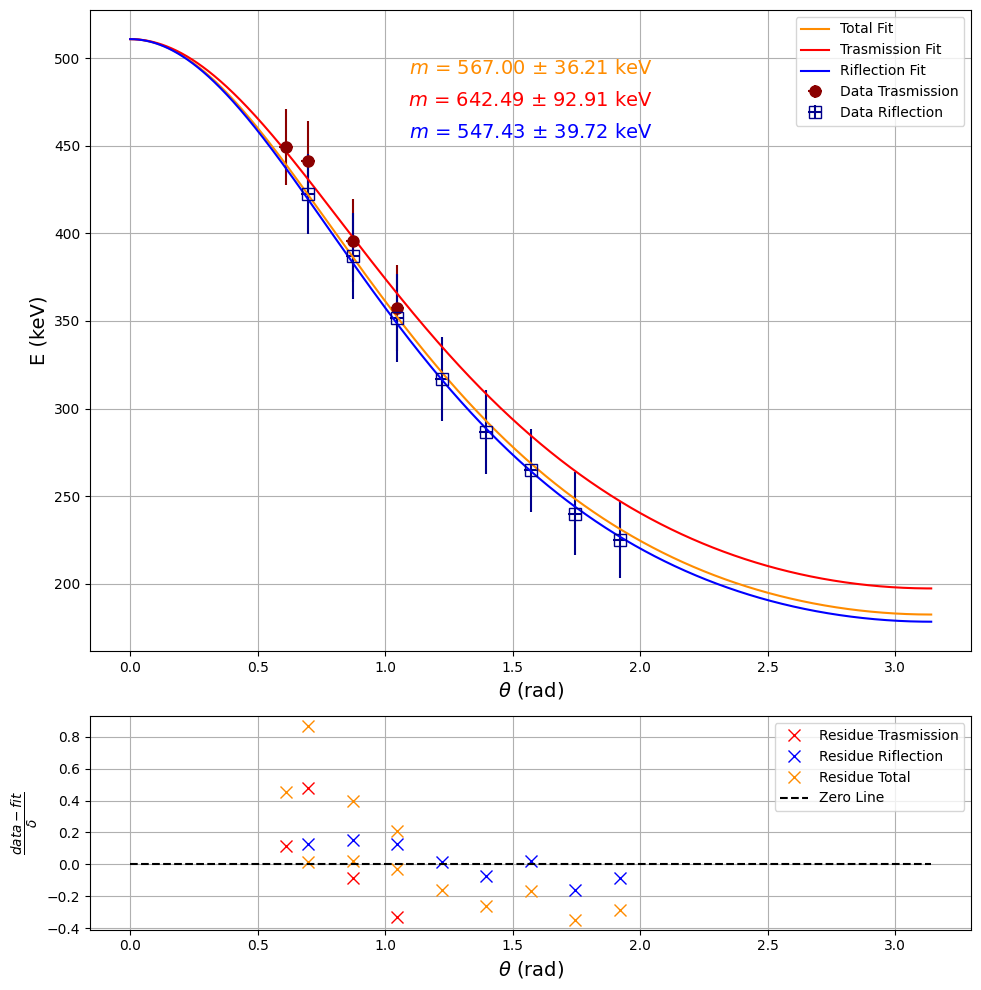

In [14]:
fig, ax = plt.subplots(2, 1, figsize=(10, 10), gridspec_kw={'height_ratios': [3, 1]})
ax[0].errorbar(angle_trasm, energies_trasm, 
             yerr=y_err_trasm, 
             xerr=x_err_trasm, 
             fmt='o', 
             label="Data Trasmission", 
             markersize=8,
             color='darkred')  

ax[0].errorbar(angle, energies, 
             yerr=y_err, 
             xerr=x_err, 
             fmt='s', 
             label="Data Riflection",
             markersize=8, 
             markerfacecolor='none', 
             markeredgecolor="darkblue",
             ecolor='darkblue')
ax[0].plot(thetas, fit_function(thetas, a_fit_tot), label="Total Fit", color='darkorange')
ax[0].plot(thetas, fit_function(thetas, a_fit_trasmission), label="Trasmission Fit", color='red')
ax[0].plot(thetas, fit_function(thetas, a_fit_reflection), label="Riflection Fit", color='blue')

ax[0].text(0.5, 0.9, rf"$m$ = {a_fit_tot:.2f} ± {a_err_tot:.4g} keV", color='darkorange', fontsize=14, transform=ax[0].transAxes, ha='center')
ax[0].text(0.5, 0.85, rf"$m$ = {a_fit_trasmission:.5g} ± {a_err_trasmission:.4g} keV", color='red', fontsize=14, transform=ax[0].transAxes, ha='center')
ax[0].text(0.5, 0.8, rf"$m$ = {a_fit_reflection:.5g} ± {a_err_reflection:.4g} keV", color='blue', fontsize=14, transform=ax[0].transAxes, ha='center')

ax[0].set_xlabel(r"$\theta$ (rad)", fontsize=14)
ax[0].set_ylabel(r"E (keV)", fontsize=14)
ax[0].legend()
ax[0].grid()

residue_trasm = (energies_trasm - fit_function(angle_trasm, a_fit_trasmission)) / y_err_trasm
residue_riflex = (energies - fit_function(angle, a_fit_reflection)) / y_err
residue_tot = (data_tot - fit_function(angle_tot, a_fit_tot)) / data_err

ax[1].plot(angle_trasm, residue_trasm, 'x', label='Residue Trasmission', color='red', markersize=8)
ax[1].plot(angle, residue_riflex, 'x', label='Residue Riflection', color='blue', markersize=8)
ax[1].plot(angle_tot, residue_tot, 'x', label='Residue Total', color='darkorange', markersize=8)
ax[1].hlines(0, 0, np.pi, colors='black', linestyles='dashed', label='Zero Line')
ax[1].set_xlabel(r"$\theta$ (rad)", fontsize=14)
ax[1].set_ylabel(r"$\frac{data - fit}{\delta}$", fontsize=14)
ax[1].legend()
ax[1].grid()

plt.tight_layout()
plt.savefig("Energy_fits.png")
plt.show()

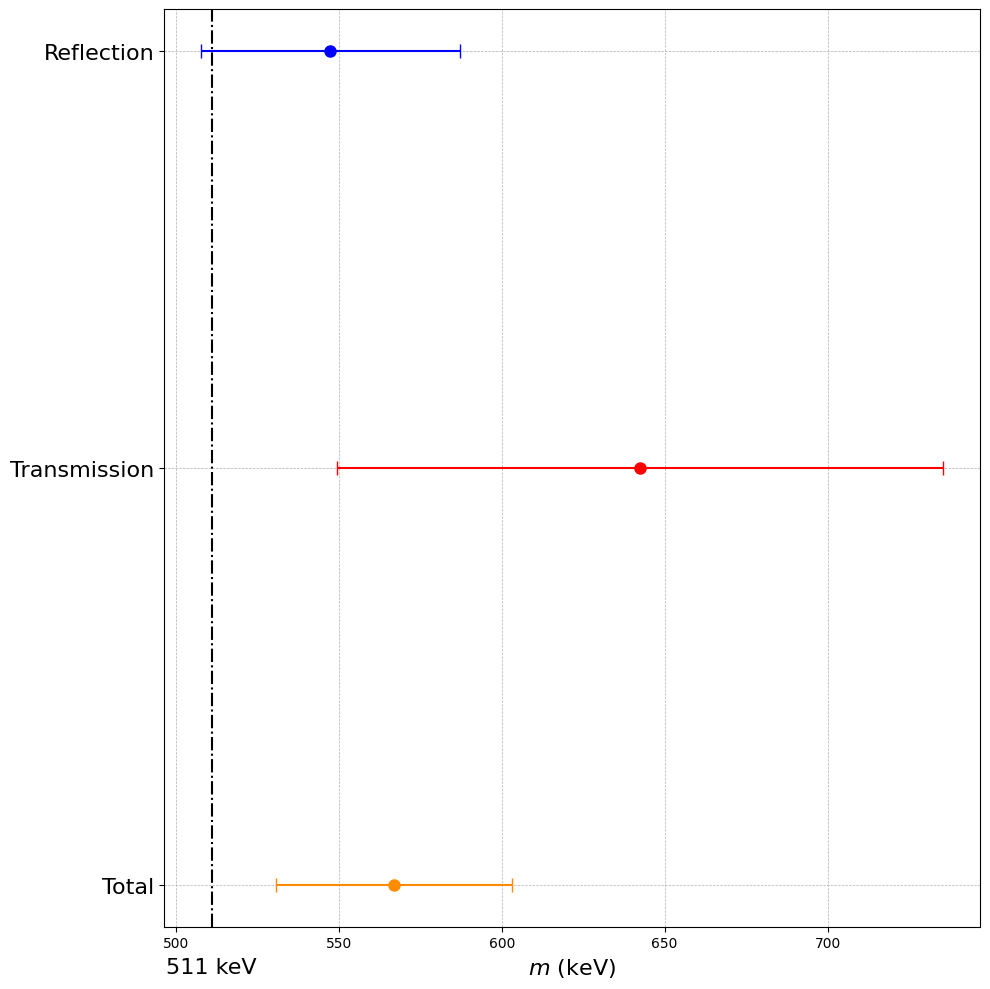

In [15]:
# # Valori stimati e incertezze
# m_values = np.array([a_fit_trasmission, a_fit_reflection])
# m_errors = np.array([a_err_trasmission, a_err_reflection])

# # Calcolo del valore medio pesato
# weights = 1 / m_errors**2
# m_weighted = np.sum(m_values * weights) / np.sum(weights)
# m_true = 511  # Valore atteso di m_e in keV

# # Calcolo del Chi^2
# chi2 = np.sum(((m_values - m_weighted)**2) / m_errors**2)
# ndof = len(m_values) - 1  # Gradi di libertà

# # Stampa dei risultati
# print(f"Valore medio pesato di m: {m_weighted:.5g} keV")
# print(f"Chi^2: {chi2:.2f}")
# print(f"Gradi di libertà (NDF): {ndof}")
# print(f"Chi^2 ridotto: {chi2 / ndof:.2f}")

# # Calcolo dell'errore sulla media pesata
# err_m_weighted = np.sum(m_errors * weights) / np.sum(weights)

# Creazione del plot
fig, ax = plt.subplots(figsize=(10, 10))

# Dati per il plot
y_labels = ['Reflection', 'Transmission', 'Total']
y_pos = np.arange(len(y_labels))
m_plot_values = [a_fit_reflection, a_fit_trasmission, a_fit_tot]
m_plot_errors = [a_err_reflection, a_err_trasmission, a_err_tot]
colors = ['blue', 'red', 'darkorange']

# Plot delle singole misure con barre d'errore
for i in range(len(y_labels)):
    ax.errorbar(m_plot_values[i], y_pos[i], xerr=m_plot_errors[i], fmt='o', color=colors[i], capsize=5, markersize=8)

# # Plot della banda verticale per la media pesata (media ± 1 std)
# ax.axvline(x=m_weighted, color='mediumturquoise', linestyle='--')
# ax.axvspan(m_weighted - err_m_weighted, m_weighted + err_m_weighted, alpha=0.3, color='lightseagreen')
# ax.text(m_weighted + 50, 1.5, rf'$m$= {m_weighted:.2f} ± {err_m_weighted:.2f} keV', fontsize=18, color='lightseagreen')

# Plot della linea verticale per il valore atteso
ax.axvline(x=511, color='black', linestyle='-.')
ax.text(511, -0.033, '511 keV', transform=ax.get_xaxis_transform(), ha='center', va='top', fontsize=16, color='black')

# Impostazioni del grafico
ax.set_yticks(y_pos)
ax.set_yticklabels(y_labels, fontsize=16)
ax.set_xlabel(r"$m$ (keV)", fontsize=16)
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Inverti l'asse y per avere "Total" in basso
ax.invert_yaxis()

plt.tight_layout()
plt.savefig("Result_Energy.png")
plt.show()


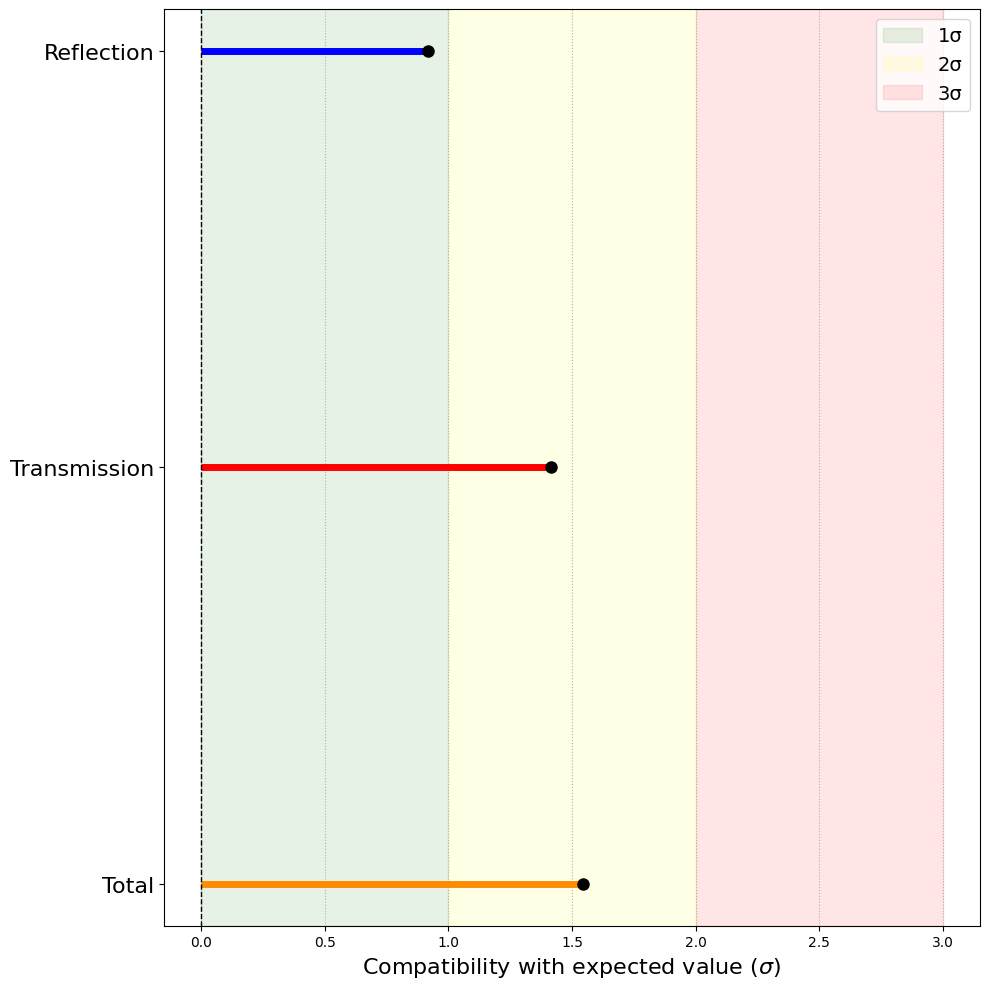

In [16]:
all_labels = ['Reflection', 'Transmission', 'Total']
all_values = np.array([a_fit_reflection, a_fit_trasmission, a_fit_tot])
all_errors = np.array([a_err_reflection, a_err_trasmission, a_err_tot])

# Valore di riferimento
true_value = 511  # keV

# Calcolo del pull: (valore_misurato - valore_vero) / errore_misura
pulls = (all_values - true_value) / all_errors

# --- Creazione del Plot ---
fig, ax = plt.subplots(figsize=(10, 10))
y_pos = np.arange(len(all_labels))
colors = ['blue', 'red', 'darkorange', 'lightseagreen']

# Plotto i punti con una linea orizzontale da 0 al valore del pull
ax.hlines(y=y_pos, xmin=0, xmax=pulls, color=colors, lw=5)
ax.plot(pulls, y_pos, "o", color='black', markersize=8) # Aggiungo un punto alla fine di ogni linea

# Linea di riferimento a 0 (accordo perfetto)
ax.axvline(0, color='black', linestyle='--', lw=1)

# Bande di compatibilità a 1, 2, e 3 sigma
ax.axvspan(0, 1, alpha=0.1, color='green', label='1σ')
ax.axvspan(1, 2, alpha=0.1, color='yellow', label='2σ')
ax.axvspan(2, 3, alpha=0.1, color='red', label='3σ')

# --- Impostazioni del Grafico ---
ax.set_yticks(y_pos)
ax.set_yticklabels(all_labels, fontsize=16)
ax.set_xlabel(r'Compatibility with expected value ($\sigma$)', fontsize=16)
ax.grid(axis='x', linestyle=':', which='both')
ax.legend(fontsize=14)

# Inverti l'asse y per avere "Reflection" in alto
ax.invert_yaxis()

plt.tight_layout()
plt.savefig("Compatibility_Energy.png")
plt.show()